In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

import models

2022-04-22 15:37:11.984887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-22 15:37:12.005976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3699850000 Hz
2022-04-22 15:37:12.006368: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5616cc119120 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-22 15:37:12.006387: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [2]:
cces = pd.read_csv('data/cces_df.csv', index_col=0)
cces_all = pd.read_csv('data/cces_all_df.csv', index_col=0)
cces_weighted = pd.read_csv('data/cces_weighted_df.csv', index_col=0)

In [3]:
cces

,abortion,eth,male,age,educ,repvote,region,state
1,1,White,-0.5,60-69,4-Year College,0.504080,North Central,WI
2,1,White,-0.5,60-69,HS,0.427158,Northeast,NJ
3,0,White,-0.5,40-49,HS,0.506188,South,FL
4,1,White,0.5,70+,Some college,0.506188,South,FL
5,0,White,-0.5,50-59,Some college,0.409799,North Central,IL
...,...,...,...,...,...,...,...,...
4996,0,White,0.5,50-59,4-Year College,0.338718,West,CA
4997,0,White,0.5,18-29,Some college,0.518900,West,AZ
4998,1,White,0.5,50-59,HS,0.473167,West,CO
4999,1,White,-0.5,50-59,HS,0.506188,South,FL


## Transform data

In [4]:
# Fills in the dictionary so that we know which index corresponds to what state / eth / edu etc.

data_to_idx = {}
list_of_states_and_votes = []
list_of_states = []
state = 0
age = 50
eth = 56
educ = 60
male_eth = 65
educ_age = 73
educ_eth = 103
for i in range(1, len(cces_all)+1):
    tup = (cces_all.loc[i,'state'], cces_all.loc[i,'repvote'])
    if cces_all.loc[i,'state'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'state']] = state
        state += 1
    if tup not in list_of_states_and_votes:
        list_of_states_and_votes.append(tup)
    if cces_all.loc[i,'age'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'age']] = age
        age += 1
    if cces_all.loc[i,'eth'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'eth']] = eth
        eth += 1
    if cces_all.loc[i,'educ'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'educ']] = educ
        educ += 1
list_of_states_and_votes.sort(key=lambda x:x[1])
for tup in list_of_states_and_votes:
    list_of_states.append(tup[0])

In [5]:
# Create new representation of data that contains only 0 and 1

def transform_raw(cces, data_to_idx, i, 
                  state=0, age=50, eth=56, educ=60,
                  male_eth=65, educ_age=73, educ_eth=103):
    x_i = np.zeros(128)
    eth_idx = data_to_idx[cces.loc[i,'eth']]
    age_idx = data_to_idx[cces.loc[i,'age']]
    educ_idx = data_to_idx[cces.loc[i,'educ']]
    x_i[data_to_idx[cces.loc[i,'state']]] = 1
    x_i[age_idx] = 1
    x_i[eth_idx] = 1
    x_i[educ_idx] = 1
    
    is_male = int(cces.loc[i,'male'] + 0.5)
    male_eth_idx = male_eth + is_male * 4 + (eth_idx-eth) 
    educ_age_idx = educ_age + (educ_idx-educ) * 6 + (age_idx-age)
    educ_eth_idx = educ_eth + (educ_idx-educ) * 4 + (eth_idx-eth)
    x_i[male_eth_idx] = 1
    x_i[educ_age_idx] = 1
    x_i[educ_eth_idx] = 1
    
    x_i[123] = is_male
    x_i[124] = int(cces.loc[i,'region'] == 'South')
    x_i[125] = int(cces.loc[i,'region'] == 'North Central')
    x_i[126] = int(cces.loc[i,'region'] == 'West')
    x_i[127] = cces.loc[i,'repvote']
    
    return x_i

x = []
y = []
for i in range(1, len(cces)+1):
    x_i = transform_raw(cces, data_to_idx, i)
    
    x.append(x_i)
    y.append(cces.loc[i,'abortion'])

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

## Variational Inference

In [6]:
# model = models.VI_KLqp(dataset='survey', v_fam='flow')
# model.x = x
# model.y = y
# model.train(lr=0.003)

In [7]:
# model = models.VI_KLqp(dataset='survey', v_fam='gaussian')
# model.x = x
# model.y = y
# model.train(lr=0.01)

## Hamiltonian Score Climbing

In [8]:
# model = models.VI_KLpq(v_fam='flow', space='warped', dataset='survey', hmc_e=0.03, hmc_L=33, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.001)

In [9]:
# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01)

In [10]:
# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01, epochs=int(1e4))

In [11]:
# # MSC
# model = models.VI_KLpq(v_fam='gaussian', space='theta', dataset='survey', hmc_e=0.03, hmc_L=33, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01)

## Real MSC

In [12]:
# #MSC, i-SIR

# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, chains=2, cis=10, eps=0.5, alpha=0.95, rejuvenation=True)
# model.x = x
# model.y = y
# model.train(lr=0.01, epochs=int(1e4))

## Evaluations

In [13]:
poststrat_df = pd.read_csv('data/poststrat_df.csv')
statelevel_predictors_df = pd.read_csv('data/statelevel_predictors.csv', index_col=0)
poststrat_df = poststrat_df.merge(statelevel_predictors_df, how='left', on='state')
mrp_states_df = pd.read_csv('data/mrp_states.csv')
poststrat_df.head()

,state,eth,male,age,educ,n,repvote,region
0,AL,White,-0.5,18-29,No HS,23948,0.643741,South
1,AL,White,-0.5,18-29,HS,59378,0.643741,South
2,AL,White,-0.5,18-29,Some college,104855,0.643741,South
3,AL,White,-0.5,18-29,4-Year College,37066,0.643741,South
4,AL,White,-0.5,18-29,Post-grad,9378,0.643741,South


In [14]:
len(poststrat_df)

12000

In [15]:
# Transform raw data into 0-1 vectors:
x_poststrat = []
for i in range(len(poststrat_df)):
    x_i = transform_raw(poststrat_df, data_to_idx, i)
    x_poststrat.append(x_i)
x_poststrat = np.array(x_poststrat, dtype='float32')

In [16]:
def estimate_vi_model_rate(x_poststrat, data_to_idx, model):
    model.x = x_poststrat
    splitted_x = tf.split(model.x, [123, 5], axis=1)
    alpha = model.q.sample(10000)
    term1 = tf.matmul(splitted_x[0], tf.transpose(alpha))
    term2 = model.gamma_0
    term3 = tf.matmul(splitted_x[1], tf.reshape(model.gamma, (5, 1)))
    post_pred_mat = tf.math.sigmoid(tf.squeeze(term1 + term2 + term3))

    return post_pred_mat

def get_se_bernoulli(p, n):
    return np.sqrt(p*(1-p)/n)

In [17]:
# 5,000-person unadjusted sample estimate:
print('mean', np.mean(cces['abortion']))
print('std', get_se_bernoulli(np.mean(cces['abortion']), len(cces)))

mean 0.4314
std 0.007004199311841433


In [18]:
# 60,000-person unadjusted sample estimate:
print('mean', np.mean(cces_all['abortion']))
print('std', get_se_bernoulli(np.mean(cces_all['abortion']), len(cces_all)))

mean 0.4341581675305133
std 0.002026677342749567


In [19]:
# # load model VI KLqp Gaussian
# path = 'results/survey/vi_klqp_gaussian/2021-10-13-172522/'
# model_qp = models.VI_KLqp(dataset='survey', v_fam='gaussian')
# model_qp.x = x
# model_qp.y = y
# model_qp.gamma_0 = np.genfromtxt(path + 'gamma_0.csv', dtype='float32')[-1]
# model_qp.gamma = np.genfromtxt(path + 'gamma.csv', dtype='float32')[-1,:]
# model_qp.phi_m = np.genfromtxt(path + 'phi_m.csv', dtype='float32')[-1,:]
# model_qp.phi_s = np.genfromtxt(path + 'phi_s.csv', dtype='float32')[-1,:]
# model_qp.sigma = np.genfromtxt(path + 'sigma.csv', dtype='float32')[-1,:]
# model_qp.q = tfd.MultivariateNormalDiag(
#               loc=model_qp.phi_m, 
#               scale_diag=model_qp.phi_s)

In [20]:
# losses = -np.genfromtxt(path + 'elbo.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [39]:
v_fam = 'gaussian'
space = 'warped'

tsc_path = sorted(list(Path(f'results/survey/vi_klpq_N0_{space}_{v_fam}').glob('*')))[-1]
N = 20
ex2_warp_path = sorted(list(Path(f'results/survey/vi_klpq_N{N}_{space}_{v_fam}').glob('*')))[-1]
ex2_warp_rao_path = sorted(list(Path(f'results/survey/vi_klpq_N{N}_{space}_{v_fam}_rao').glob('*')))[-1]

In [22]:
# load model VI KLpq Gaussian - HSC
#path = Path('results/survey/vi_klpq_N0_warped_gaussian/2022-04-18-102854')
model_pq = models.VI_KLpq(v_fam=v_fam, space='warped', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
model_pq.x = x
model_pq.y = y
model_pq.gamma_0 = np.genfromtxt(tsc_path / 'gamma_0.csv', dtype='float32')[-1]
model_pq.gamma = np.genfromtxt(tsc_path / 'gamma.csv', dtype='float32')[-1,:]
model_pq.phi_m = np.genfromtxt(tsc_path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq.phi_s = np.genfromtxt(tsc_path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq.sigma = np.genfromtxt(tsc_path / 'sigma.csv', dtype='float32')[-1,:]
model_pq.q = tfd.MultivariateNormalDiag(
    loc=model_pq.phi_m, 
    scale_diag=model_pq.phi_s)

2022-04-22 15:37:36.886904: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


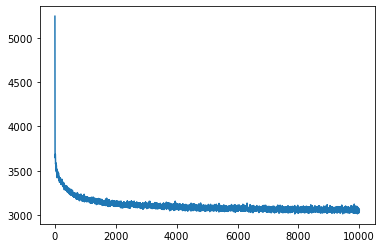

In [23]:
losses_tsc = np.genfromtxt(tsc_path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses_tsc))), losses_tsc)

In [24]:
pass # not in warped space

# # load model VI KLpq Gaussian - MSC
# path = Path('results/survey/vi_klpq_N10_eps_gaussian/2022-04-14-180124')
# model_pq_ex2_eps = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, cis=10, chains=1)
# model_pq_ex2_eps.x = x
# model_pq_ex2_eps.y = y
# model_pq_ex2_eps.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_ex2_eps.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_ex2_eps.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
# model_pq_ex2_eps.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
# model_pq_ex2_eps.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_ex2_eps.q = tfd.MultivariateNormalDiag(
#     loc=model_pq_ex2_eps.phi_m, 
#     scale_diag=model_pq_ex2_eps.phi_s)

In [25]:
# losses = np.genfromtxt(path / 'losses.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [26]:
# load model VI KLpq Gaussian - MSC

model_pq_ex2_warp = models.VI_KLpq(v_fam=v_fam, space='warped', dataset='survey', hmc_e=0.05, hmc_L=20, cis=N, chains=1)
model_pq_ex2_warp.x = x
model_pq_ex2_warp.y = y
model_pq_ex2_warp.gamma_0 = np.genfromtxt(ex2_warp_path / 'gamma_0.csv', dtype='float32')[-1]
model_pq_ex2_warp.gamma = np.genfromtxt(ex2_warp_path / 'gamma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.phi_m = np.genfromtxt(ex2_warp_path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.phi_s = np.genfromtxt(ex2_warp_path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.sigma = np.genfromtxt(ex2_warp_path / 'sigma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.q = tfd.MultivariateNormalDiag(
    loc=model_pq_ex2_warp.phi_m, 
    scale_diag=model_pq_ex2_warp.phi_s)

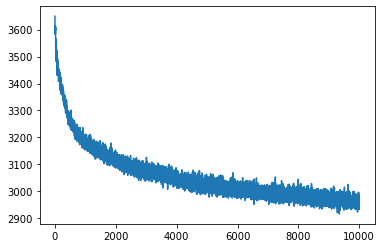

In [27]:
losses_ex2_warp = np.genfromtxt(ex2_warp_path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses_ex2_warp))), losses_ex2_warp)

In [40]:
# load model VI KLpq Gaussian - MSC

model_pq_ex2_warp_rao = models.VI_KLpq(v_fam=v_fam, space='warped', dataset='survey', hmc_e=0.05, hmc_L=20, cis=N, chains=1)
model_pq_ex2_warp_rao.x = x
model_pq_ex2_warp_rao.y = y
model_pq_ex2_warp_rao.gamma_0 = np.genfromtxt(ex2_warp_rao_path / 'gamma_0.csv', dtype='float32')[-1]
model_pq_ex2_warp_rao.gamma = np.genfromtxt(ex2_warp_rao_path / 'gamma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp_rao.phi_m = np.genfromtxt(ex2_warp_rao_path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq_ex2_warp_rao.phi_s = np.genfromtxt(ex2_warp_rao_path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq_ex2_warp_rao.sigma = np.genfromtxt(ex2_warp_rao_path / 'sigma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp_rao.q = tfd.MultivariateNormalDiag(
    loc=model_pq_ex2_warp_rao.phi_m, 
    scale_diag=model_pq_ex2_warp_rao.phi_s)

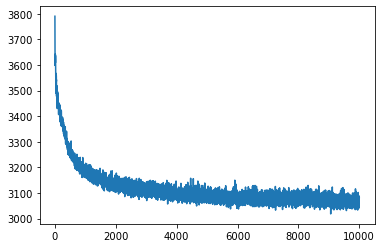

In [47]:
losses_ex2_warp_rao = np.genfromtxt(ex2_warp_rao_path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses_ex2_warp_rao))), losses_ex2_warp_rao)

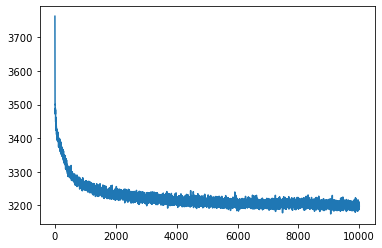

In [42]:
# losses_ex2_warp_rao = np.genfromtxt(ex2_warp_rao_path / 'losses_p.csv', dtype='float32')
# plt.plot(list(range(len(losses_ex2_warp_rao))), losses_ex2_warp_rao)

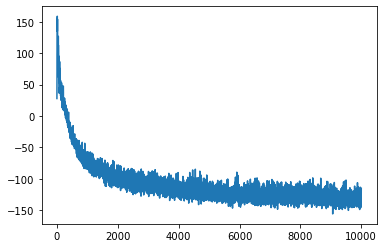

In [43]:
# losses_ex2_warp_rao = np.genfromtxt(ex2_warp_rao_path / 'losses_q.csv', dtype='float32')
# plt.plot(list(range(len(losses_ex2_warp_rao))), losses_ex2_warp_rao)

In [44]:
def ema(s, n):
    """
    returns an n period exponential moving average for
    the time series s

    s is a list ordered from oldest (index 0) to most
    recent (index -1)
    n is an integer

    returns a numeric array of the exponential
    moving average
    """
    s = np.array(s)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(s[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (s[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in s[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

Text(0, 0.5, '$-\\mathbb{E}\\log[p(x \\mid z)p(z)] - \\mathbb{E}\\log[\\log q(x \\mid z)]$')

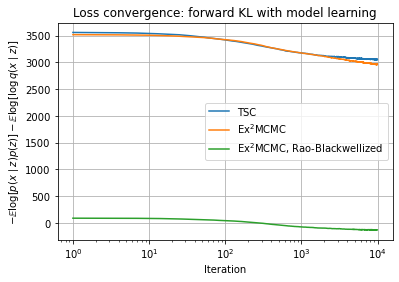

In [45]:
arange = np.arange(1, len(losses_ex2_warp_rao)+1)

for loss, label in zip([losses_tsc, losses_ex2_warp, losses_ex2_warp_rao], ['TSC', r'Ex$^2$MCMC', r'Ex$^2$MCMC, Rao-Blackwellized']):
    n = 100
    plt.plot(arange[:-n+1], ema(loss, n), label=label)

plt.xscale('log')
plt.legend()
plt.grid()
plt.title('Loss convergence: forward KL with model learning')
plt.xlabel('Iteration')
plt.ylabel(r'$-\mathbb{E}\log[p(x \mid z)p(z)] - \mathbb{E}\log[\log q(x \mid z)]$')
#plt.savefig(Path('figs', 'survey_data_loss_logscale.png'))

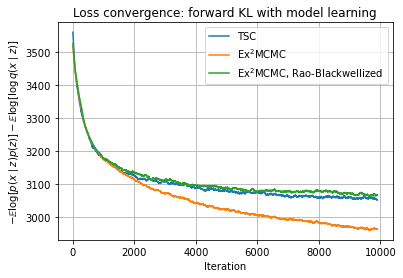

In [48]:
arange = np.arange(1, len(losses_ex2_warp_rao)+1)

for loss, label in zip([losses_tsc, losses_ex2_warp, losses_ex2_warp_rao], ['TSC', r'Ex$^2$MCMC', r'Ex$^2$MCMC, Rao-Blackwellized']):
    n = 100
    plt.plot(arange[:-n+1], ema(loss, n), label=label)

# plt.xscale('log')
plt.legend()
plt.grid()
plt.title('Loss convergence: forward KL with model learning')
plt.xlabel('Iteration')
plt.ylabel(r'$-\mathbb{E}\log[p(x \mid z)p(z)] - \mathbb{E}\log[\log q(x \mid z)]$')
plt.savefig(Path('figs', 'survey_data_loss.png'))

In [ ]:
# # load model VI KLqp Flow
# path = 'results/survey/vi_klqp_flow/2021-09-03-223300/'
# model_qp_flow = models.VI_KLqp(v_fam='flow', dataset='survey')
# model_qp_flow.x = x
# model_qp_flow.y = y
# model_qp_flow.gamma_0 = np.genfromtxt(path + 'gamma_0.csv', dtype='float32')[-1]
# model_qp_flow.gamma = np.genfromtxt(path + 'gamma.csv', dtype='float32')[-1,:]
# model_qp_flow.sigma = np.genfromtxt(path + 'sigma.csv', dtype='float32')[-1,:]
# model_qp_flow.load_model(path + 'flow_model/model')

In [ ]:
# losses = -np.genfromtxt(path + 'elbo.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [ ]:
# # load model VI KLpq Flow
#path = Path('results/survey/vi_klpq_N0_warped_flow/2022-04-18-105801')
# model_pq_flow = models.VI_KLpq(v_fam='flow', space='warped', dataset='survey', hmc_e=0.03, hmc_L=33, chains=64)
# model_pq_flow.x = x
# model_pq_flow.y = y
# model_pq_flow.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_flow.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_flow.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_flow.load_model(path / 'flow_model/model')

In [ ]:
# losses = np.genfromtxt(path + 'losses.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [ ]:
# load model VI KLpq Flow - MSC
#path = Path('results/survey/vi_klpq_N10_warped_flow/2022-04-15-000944')
# model_pq_ex2_flow_warp = models.VI_KLpq(v_fam='flow', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, cis=10, chains=1)
# model_pq_ex2_flow_warp.x = x
# model_pq_ex2_flow_warp.y = y
# model_pq_ex2_flow_warp.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_ex2_flow_warp.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_ex2_flow_warp.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
# model_pq_ex2_flow_warp.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
# model_pq_ex2_flow_warp.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_ex2_flow_warp.q = tfd.MultivariateNormalDiag(
#     loc=model_pq_ex2_flow_warp.phi_m, 
#     scale_diag=model_pq_ex2_flow_warp.phi_s)

In [ ]:
# losses = np.genfromtxt(path + 'losses.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [ ]:
# load model VI KLpq Flow - MSC
#path = Path('results/survey/vi_klpq_N10_warped_flow/2022-04-14-183205')
# model_pq_ex2_warp = models.VI_KLpq(v_fam='flow', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, cis=10, chains=1)
# model_pq_ex2_warp.x = x
# model_pq_ex2_warp.y = y
# model_pq_ex2_warp.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_ex2_warp.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.q = tfd.MultivariateNormalDiag(
#     loc=model_pq_ex2_warp.phi_m, 
#     scale_diag=model_pq_ex2_warp.phi_s)

In [ ]:
# post_pred_mat_qp = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_qp)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

In [ ]:
post_pred_mat_pq = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq)
estimate = np.dot(np.array([poststrat_df['n']]), 
                  np.array(post_pred_mat_pq)) / sum(poststrat_df['n'])
print('mean', np.mean(estimate))
print('std', np.std(estimate))

mean 0.4343460696050466
std 0.02296525438953359


In [ ]:
# post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_eps)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_pq_msc)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

In [ ]:
# post_pred_mat_qp_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp_flow)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_qp_flow)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

In [ ]:
pass
# post_pred_mat_pq_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_flow)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_pq_flow)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

Compare parameters under different number of VI samples

In [ ]:
# path = 'results/survey/vi_klpq_gaussian/2021-09-01-162133/'
# gamma = np.genfromtxt(path + 'gamma.csv')
# plt.plot(gamma[:,0], label='gamma_1')
# plt.plot(gamma[:,1], label='gamma_2')
# plt.plot(gamma[:,2], label='gamma_3')
# plt.plot(gamma[:,3], label='gamma_4')
# plt.plot(gamma[:,4], label='gamma_5')
# plt.show()

In [ ]:
# path = 'results/survey/vi_klpq_gaussian/2021-07-02-164958/'
# gamma_1samp = np.genfromtxt(path + 'gamma.csv')
# plt.plot(gamma_1samp[:,0], label='gamma_1')
# plt.plot(gamma_1samp[:,1], label='gamma_2')
# plt.plot(gamma_1samp[:,2], label='gamma_3')
# plt.plot(gamma_1samp[:,3], label='gamma_4')
# plt.plot(gamma_1samp[:,4], label='gamma_5')
# plt.show()

### By-state predictions

By state

In [ ]:
# post_pred_mat_qp = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp)
# state_means_qp = []
# state_stds_qp = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_qp)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_qp.append(np.mean(estimate))
#     state_stds_qp.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_qp = np.array(state_means_qp)
# state_stds_qp = np.array(state_stds_qp)

In [55]:
post_pred_mat_pq = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq)
state_means_pq = []
state_stds_pq = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq.append(np.mean(estimate))
    state_stds_pq.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq = np.array(state_means_pq)
state_stds_pq = np.array(state_stds_pq)

HI
mean 0.35083895902513423
std 0.045514782771735054
CA
mean 0.3811066971954942
std 0.03010147337325628
VT
mean 0.3973144201114362
std 0.04737873200650373
MA
mean 0.34226028368163913
std 0.037229892091678554
MD
mean 0.3484454241836251
std 0.03766045822075124
NY
mean 0.35192001040465226
std 0.031723779542632315
IL
mean 0.398952076635959
std 0.03475328535520485
WA
mean 0.37651624555728486
std 0.03793167222310804
RI
mean 0.37308226502154057
std 0.046451263265959074
NJ
mean 0.36750558376456466
std 0.037268581047846465
CT
mean 0.3502699591716917
std 0.0412128700046722
OR
mean 0.38626164650561307
std 0.04264738931812452
DE
mean 0.44656129871905187
std 0.04566379915928619
NM
mean 0.39725131222465765
std 0.0417116985422804
VA
mean 0.436291310429568
std 0.03695241109055791
CO
mean 0.40974538888854556
std 0.040360882456798336
ME
mean 0.42641882018250354
std 0.04881446888729939
NV
mean 0.39473753689295665
std 0.03969884252070336
MN
mean 0.4269229083725784
std 0.04376134197727272
NH
mean 0.4098715

In [ ]:
# post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_eps)
# state_means_pq_ex2_eps = []
# state_stds_pq_ex2_eps = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_pq_msc)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_pq_ex2_eps.append(np.mean(estimate))
#     state_stds_pq_ex2_eps.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_pq_msc = np.array(state_means_pq_ex2_eps)
# state_stds_pq_ex2_eps = np.array(state_stds_pq_ex2_eps)

In [ ]:
post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_warp)
state_means_pq_ex2_warp = []
state_stds_pq_ex2_warp = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq_msc)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq_ex2_warp.append(np.mean(estimate))
    state_stds_pq_ex2_warp.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq_ex2_warp = np.array(state_means_pq_ex2_warp)
state_stds_pq_ex2_warp = np.array(state_stds_pq_ex2_warp)

HI
mean 0.36020810902384814
std 0.03638140730859602
CA
mean 0.37518992333247286
std 0.02301274033618245
VT
mean 0.38538672732129875
std 0.03548017934024563
MA
mean 0.3433566605364496
std 0.028673386369258484
MD
mean 0.350750077906214
std 0.030631656094274186
NY
mean 0.3542579600052468
std 0.024081133523787195
IL
mean 0.40015848938000514
std 0.028026719275279947
WA
mean 0.38310708005183564
std 0.03041410794691814
RI
mean 0.3700079061625178
std 0.03465361023758425
NJ
mean 0.36868284334838847
std 0.028581637490254608
CT
mean 0.35932695661233255
std 0.0328444956315099
OR
mean 0.39456061165010414
std 0.032401949150551376
DE
mean 0.44190509064181377
std 0.03461731556943685
NM
mean 0.4011525628856792
std 0.03329882471476353
VA
mean 0.43295283367575593
std 0.028661368604935716
CO
mean 0.4133084788124115
std 0.032747398840405846
ME
mean 0.42789511376938383
std 0.03541709390031422
NV
mean 0.3991248952957
std 0.031024325308917237
MN
mean 0.432417289537546
std 0.03311185031770461
NH
mean 0.4188732

In [ ]:
len(estimate)

1

In [49]:
post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_warp_rao)
state_means_pq_ex2_warp_rao = []
state_stds_pq_ex2_warp_rao = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq_msc)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq_ex2_warp_rao.append(np.mean(estimate))
    state_stds_pq_ex2_warp_rao.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq_ex2_warp_rao = np.array(state_means_pq_ex2_warp_rao)
state_stds_pq_ex2_warp_rao = np.array(state_stds_pq_ex2_warp_rao)

HI
mean 0.35831790797494134
std 0.0447257486264397
CA
mean 0.3784676879227611
std 0.02959880419280698
VT
mean 0.3908227994405959
std 0.04650119327876723
MA
mean 0.3412874145060871
std 0.03640627732457338
MD
mean 0.3429812627781031
std 0.03658183547090757
NY
mean 0.3533940080753754
std 0.030874552343244863
IL
mean 0.401632634942411
std 0.03435117198751584
WA
mean 0.38054980293251356
std 0.03775931374764106
RI
mean 0.36302595813535954
std 0.044931078818322805
NJ
mean 0.36902550664162453
std 0.03596137652137714
CT
mean 0.3532468215497802
std 0.04060624716602864
OR
mean 0.3906405756061964
std 0.04249667126735412
DE
mean 0.4418084714395136
std 0.0457369214263063
NM
mean 0.4010928386637457
std 0.043142420131397886
VA
mean 0.4273030703810495
std 0.03627754350573634
CO
mean 0.4124834884679728
std 0.041250815268291524
ME
mean 0.4286410786023935
std 0.04683305291843891
NV
mean 0.39387419581632466
std 0.03963949149271982
MN
mean 0.43355989548841556
std 0.0426617099596839
NH
mean 0.416228443280307

In [50]:
# post_pred_mat_qp_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp_flow)
# state_means_qp_flow = []
# state_stds_qp_flow = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_qp_flow)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_qp_flow.append(np.mean(estimate))
#     state_stds_qp_flow.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_qp_flow = np.array(state_means_qp_flow)
# state_stds_qp_flow = np.array(state_stds_qp_flow)

In [51]:
pass
# post_pred_mat_pq_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_flow)
# state_means_pq_flow = []
# state_stds_pq_flow = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_pq_flow)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_pq_flow.append(np.mean(estimate))
#     state_stds_pq_flow.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_pq_flow = np.array(state_means_pq_flow)
# state_stds_pq_flow = np.array(state_stds_pq_flow)

In [52]:
state_means_unadj_5000 = []
state_stds_unadj_5000 = []
for state in list_of_states:
    is_state = np.array([cces['state'] == state])
    n = np.sum(is_state)
    mean = np.sum(np.multiply(np.array([cces['abortion']]), is_state))/n
    state_means_unadj_5000.append(mean)
    state_stds_unadj_5000.append(get_se_bernoulli(mean, n))
state_means_unadj_5000 = np.array(state_means_unadj_5000)
state_stds_unadj_5000 = np.array(state_stds_unadj_5000)

In [53]:
state_means_unadj_60000 = []
state_stds_unadj_60000 = []
for state in list_of_states:
    is_state = np.array([cces_all['state'] == state])
    n = np.sum(is_state)
    mean = np.sum(np.multiply(np.array([cces_all['abortion']]), is_state))/n
    state_means_unadj_60000.append(mean)
    state_stds_unadj_60000.append(get_se_bernoulli(mean, n))
state_means_unadj_60000 = np.array(state_means_unadj_60000)
state_stds_unadj_60000 = np.array(state_stds_unadj_60000)

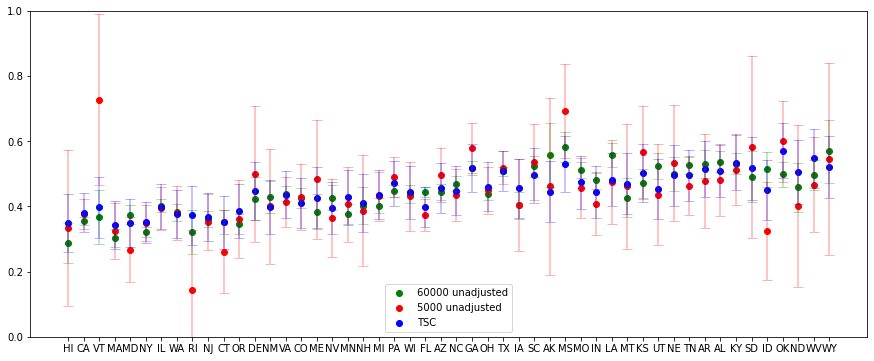

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_unadj_5000, color='r', label='5000 unadjusted')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')


plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_unadj_5000, 
             yerr=1.96*state_stds_unadj_5000, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)

plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_unadj.png')
plt.show()

In [ ]:
# plt.figure(figsize=(15, 6))
# plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
# plt.scatter(list_of_states, state_means_pq_ex2_eps, color='black', label=r'Ex$^2$MCMC, space=eps')
# plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
# plt.errorbar(list_of_states, 
#              state_means_unadj_60000, 
#              yerr=1.96*state_stds_unadj_60000, 
#              linestyle='', color='g', alpha=0.3, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq_ex2_eps, 
#              yerr=1.96*state_stds_pq_ex2_eps, 
#              linestyle='', color='black', alpha=0.3, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq, 
#              yerr=1.96*state_stds_pq, 
#              linestyle='', color='b', alpha=0.3, capsize=5.0)
# plt.ylim(0, 1)
# plt.legend()
# plt.savefig(Path('figs') / 'survey_tsc_ex2_eps.png')
# plt.show()

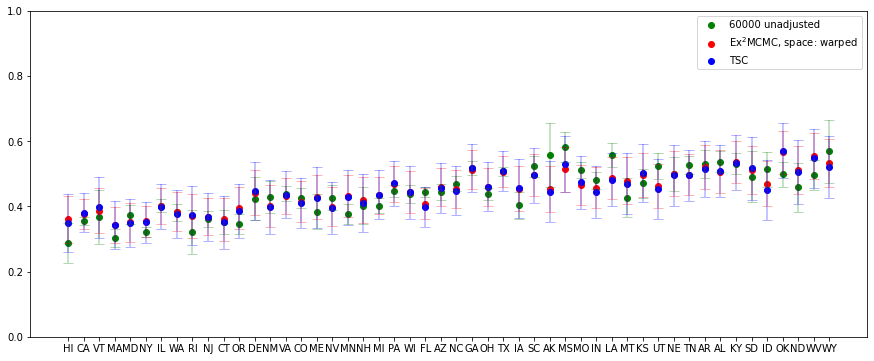

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_pq_ex2_warp, color='red', label=fr'Ex$^2$MCMC, space: {space}')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq_ex2_warp, 
             yerr=1.96*state_stds_pq_ex2_warp, 
             linestyle='', color='red', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / f'survey_tsc_ex2_{space}.png')
plt.show()

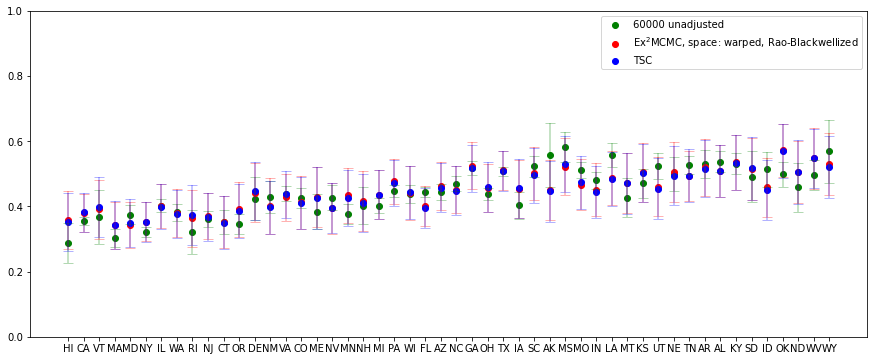

In [57]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_pq_ex2_warp_rao, color='red', label=fr'Ex$^2$MCMC, space: {space}, Rao-Blackwellized')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq_ex2_warp_rao, 
             yerr=1.96*state_stds_pq_ex2_warp_rao, 
             linestyle='', color='red', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / f'survey_tsc_ex2_{space}_rao.png')
plt.show()

In [ ]:
pass # TSC Flow

# plt.figure(figsize=(15, 6))
# plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
# #plt.scatter(list_of_states, state_means_qp_flow, color='r', label='VI with flow')
# plt.scatter(list_of_states, state_means_pq_flow, color='b', label='TSC with flow')
# plt.errorbar(list_of_states, 
#              state_means_unadj_60000, 
#              yerr=1.96*state_stds_unadj_60000, 
#              linestyle='', color='g', alpha=0.0, capsize=5.0)
# # plt.errorbar(list_of_states, 
# #              state_means_qp_flow, 
# #              yerr=1.96*state_stds_qp_flow, 
# #              linestyle='', color='r', alpha=0.3, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq_flow, 
#              yerr=1.96*state_stds_pq_flow, 
#              linestyle='', color='b', alpha=0.3, capsize=5.0)
# plt.ylim(0, 1)
# plt.legend()
# plt.savefig(Path('figs') / 'survey_tsc_vi.png')
# plt.show()

In [ ]:
# VI

# plt.figure(figsize=(15, 6))
# plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
# #plt.scatter(list_of_states, state_means_qp, color='r', label='VI with Gaussian')
# plt.scatter(list_of_states, state_means_pq, color='b', label='HSC with Gaussian')
# plt.errorbar(list_of_states, 
#              state_means_unadj_60000, 
#              yerr=1.96*state_stds_unadj_60000, 
#              linestyle='', color='g', alpha=0.2, capsize=5.0)
# # plt.errorbar(list_of_states, 
# #              state_means_qp, 
# #              yerr=1.96*state_stds_qp, 
# #              linestyle='', color='r', alpha=0.3, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq, 
#              yerr=1.96*state_stds_pq, 
#              linestyle='', color='b', alpha=0.3, capsize=5.0)
# plt.ylim(0, 1)
# plt.legend()
# plt.savefig(Path('figs') / 'survey_tsc_vi.png')
# plt.show()

In [ ]:
pass # HSC Flow

# plt.figure(figsize=(15, 6))
# plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
# plt.scatter(list_of_states, state_means_pq_flow, color='r', label='HSC with Flow')
# plt.scatter(list_of_states, state_means_pq, color='b', label='HSC')
# plt.errorbar(list_of_states, 
#              state_means_unadj_60000, 
#              yerr=1.96*state_stds_unadj_60000, 
#              linestyle='', color='g', alpha=0.2, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq_flow, 
#              yerr=1.96*state_stds_pq_flow, 
#              linestyle='', color='r', alpha=0.7, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_pq, 
#              yerr=1.96*state_stds_pq, 
#              linestyle='', color='b', alpha=0.7, capsize=5.0)
# plt.ylim(0, 1)
# plt.legend()
# plt.show()

In [ ]:
state_means_mrp = []
state_stds_mrp = []
for state in list_of_states:
    idx = mrp_states_df[mrp_states_df['state'] == state].index[0]
    state_means_mrp.append(mrp_states_df.loc[idx, 'mrp_estimate'])
    state_stds_mrp.append(mrp_states_df.loc[idx, 'mrp_estimate_se'])
state_means_mrp = np.array(state_means_mrp)
state_stds_mrp = np.array(state_stds_mrp)

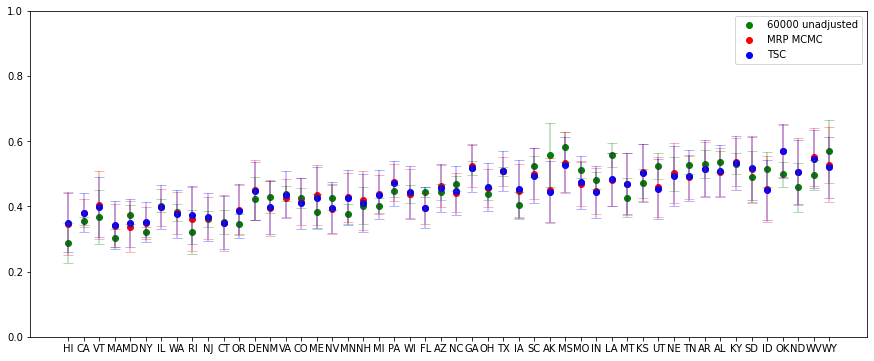

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_mrp, color='r', label='MRP MCMC')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_mrp, 
             yerr=1.96*state_stds_mrp, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_mrp.png')
plt.show()

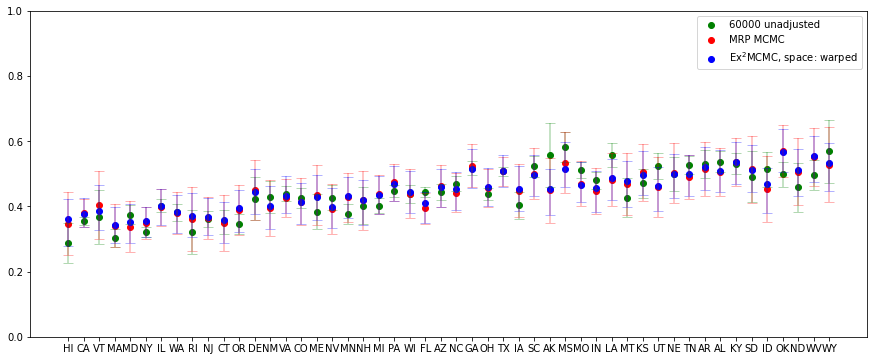

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_mrp, color='r', label='MRP MCMC')
plt.scatter(list_of_states, state_means_pq_ex2_warp, color='b', label=fr'Ex$^2$MCMC, space: {space}')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_mrp, 
             yerr=1.96*state_stds_mrp, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq_ex2_warp, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / f'survey_ex2_{space}_mrp.png')
plt.show()

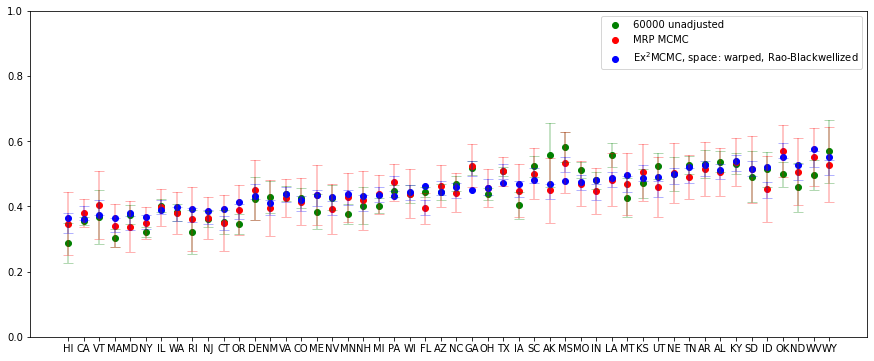

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_mrp, color='r', label='MRP MCMC')
plt.scatter(list_of_states, state_means_pq_ex2_warp_rao, color='b', label=fr'Ex$^2$MCMC, space: {space}, Rao-Blackwellized')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_mrp, 
             yerr=1.96*state_stds_mrp, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq_ex2_warp_rao, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / f'survey_ex2_{space}_mrp.png')
plt.show()

In [147]:
# print(np.sum((state_stds_pq-state_stds_mrp)**2))
# print(np.sum((state_stds_qp-state_stds_mrp)**2))

# print(np.sum((state_means_pq-state_means_mrp)**2))
# print(np.sum((state_means_qp-state_means_mrp)**2))

### Effective sample size

In [58]:
hmc_points_tsc = np.squeeze(np.array(pd.read_pickle(tsc_path /'hmc_points.pickle')))
hmc_points_ex2_warp = np.squeeze(np.array(pd.read_pickle(ex2_warp_path / 'hmc_points.pickle')))
hmc_points_ex2_warp_rao = np.squeeze(np.array(pd.read_pickle(ex2_warp_rao_path / 'hmc_points.pickle')))

In [59]:
def autocor(x, t):
    n = x.shape[0]
    mu = np.mean(x, axis=0)
    sigma2 = np.var(x, axis=0)
    numer = np.sum((x[:(n-t),:]-mu) * (x[t:,:]-mu), axis=0)
    return numer/((n-t)*sigma2)

def neff(x):
    n = x.shape[0]
    d = x.shape[1]
    autocor_arr = np.zeros((n, d))
    dim_to_set_to_0 = []
    for t in range(1, n):
        autocor_arr[t-1,:] = autocor(x, t)
        if len(dim_to_set_to_0) > 0:
            autocor_arr[t-1, dim_to_set_to_0] = 0
        if t > 1:
            for d_i in range(d):
                if autocor_arr[t-1, d_i] + autocor_arr[t-2, d_i] < 0:
                    autocor_arr[t-1, d_i] = 0
                    autocor_arr[t-2, d_i] = 0
                    if d_i not in dim_to_set_to_0:
                        dim_to_set_to_0.append(d_i)
            if len(dim_to_set_to_0) == d:
                break
    return n/(1+2*np.sum(autocor_arr, axis=0))

In [60]:
list_of_checkpt = [500, 1000, 2000, 5000, 10000] #, 20000, 30000, 50000, 100000]
num_dim = hmc_points_tsc.shape[1]
neff_list_ex2_warp = np.zeros((len(list_of_checkpt), num_dim))

for i in range(len(list_of_checkpt)):
    idx = list_of_checkpt[i]
    neff_list_ex2_warp[i, :] = neff(hmc_points_ex2_warp[:idx, :])
    print(i, np.mean(neff_list_ex2_warp[i,:]/idx))

0 0.12056227851225085
1 0.10888163453905535
2 0.10322373357102134
3 0.06105566981068105
4 0.030527834905340525


In [61]:
list_of_checkpt = [500, 1000, 2000, 5000, 10000] #, 20000, 30000, 50000, 100000]
num_dim = hmc_points_tsc.shape[1]
neff_list_ex2_warp_rao = np.zeros((len(list_of_checkpt), num_dim))

for i in range(len(list_of_checkpt)):
    idx = list_of_checkpt[i]
    neff_list_ex2_warp_rao[i, :] = neff(hmc_points_ex2_warp_rao[:idx, :])
    print(i, np.mean(neff_list_ex2_warp_rao[i,:]/idx))

0 0.12084213228718658
1 0.11317429779343186
2 0.10500553543777996
3 0.10462122501158848
4 0.11547023345568054


In [62]:
neff_list_tsc = np.zeros((len(list_of_checkpt), num_dim))

for i in range(len(list_of_checkpt)):
    idx = list_of_checkpt[i]
    neff_list_tsc[i, :] = neff(hmc_points_tsc[:idx, :])
    print(i, np.mean(neff_list_tsc[i,:]/idx))

0 0.11442116784158353
1 0.10079683656785997
2 0.09429095674462086
3 0.09266899854655342
4 0.09452942423417489


In [63]:
np.savetxt('results/neff_list_tsc.csv', neff_list_tsc)
np.savetxt('results/neff_list_ex2_warp.csv', neff_list_ex2_warp)
np.savetxt('results/neff_list_ex2_warp_rao.csv', neff_list_ex2_warp_rao)

In [64]:
neff_list_tsc = np.genfromtxt('results/neff_list_tsc.csv')
neff_list_ex2_warp = np.genfromtxt('results/neff_list_ex2_warp.csv')
neff_list_ex2_warp_rao = np.genfromtxt('results/neff_list_ex2_warp_rao.csv')
list_of_checkpt = [500, 1000, 2000, 5000, 10000] #, 20000, 30000, 50000, 100000]

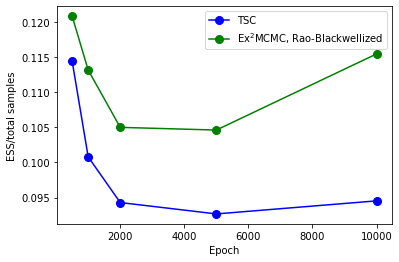

In [66]:
import matplotlib.pylab as pylab

# params = {'legend.fontsize': 'x-large',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# pylab.rcParams.update(params)

plt.plot(list_of_checkpt, 
         np.mean(neff_list_tsc, axis=1)/np.array(list_of_checkpt),
         marker='o', markersize=8, color='b',
         label='TSC')
# plt.plot(list_of_checkpt, 
#          np.mean(neff_list_ex2_warp, axis=1)/np.array(list_of_checkpt),
#          marker='o', markersize=8, color='r',
#          label=r'Ex$^2$MCMC')
plt.plot(list_of_checkpt, 
         np.mean(neff_list_ex2_warp_rao, axis=1)/np.array(list_of_checkpt),
         marker='o', markersize=8, color='g',
         label=r'Ex$^2$MCMC, Rao-Blackwellized')

plt.legend()
plt.ylabel('ESS/total samples')
plt.xlabel('Epoch')
plt.savefig(Path('figs') / 'survey_ess.png')

# THE END

## Transform Weighted Data and Run Methods

In [ ]:
x_weighted = []
y_weighted = []
state = 0
age = 50
eth = 56
educ = 60
male_eth = 65
educ_age = 73
educ_eth = 103
for i in range(1, len(cces)+1):
    x_i = np.zeros(128)
    eth_idx = data_to_idx[cces_weighted.loc[i,'eth']]
    age_idx = data_to_idx[cces_weighted.loc[i,'age']]
    educ_idx = data_to_idx[cces_weighted.loc[i,'educ']]
    x_i[data_to_idx[cces_weighted.loc[i,'state.x']]] = 1
    x_i[age_idx] = 1
    x_i[eth_idx] = 1
    x_i[educ_idx] = 1
    
    is_male = int(cces_weighted.loc[i,'male'] + 0.5)
    male_eth_idx = male_eth + is_male * 4 + (eth_idx-eth) 
    educ_age_idx = educ_age + (educ_idx-educ) * 6 + (age_idx-age)
    educ_eth_idx = educ_eth + (educ_idx-educ) * 4 + (eth_idx-eth)
    x_i[male_eth_idx] = 1
    x_i[educ_age_idx] = 1
    x_i[educ_eth_idx] = 1
    
    x_i[123] = is_male
    x_i[124] = int(cces_weighted.loc[i,'region'] == 'South')
    x_i[125] = int(cces_weighted.loc[i,'region'] == 'North Central')
    x_i[126] = int(cces_weighted.loc[i,'region'] == 'West')
    x_i[127] = cces_weighted.loc[i,'repvote']
    
    x_weighted.append(x_i)
    y_weighted.append(cces_weighted.loc[i,'abortion'])

x_weighted = np.array(x_weighted, dtype=np.float32)
y_weighted = np.array(y_weighted, dtype=np.float32)

In [ ]:
tf.nn.sigmoid_cross_entropy_with_logits(logits=[[1.,9.],[1.,9.]], labels=[[0.,1.],[1.,0.]])


Define a variational distribution q(alpha; phi) \
Define probabilistic model p(y|alpha; x, theta) \
Define prior p(alpha; theta) \
phi and theta are trainable by gradient methods \
\
for batch_x in x: 
   * sample alpha from q 
   * compute logpx_z = log p(y|alpha; batch_x, theta) 
   * compute logpz = log p(z; theta) 
   * compute logqz_x = log q(alpha; phi) 
   * elbo = logpx_z + logpz - logqz_x 
   * input -elbo as the objective into the autodiff. function
    
How to define q(alpha; phi):
* Gaussian with diagonal covariance
* In a separate implementation, q can also be a flow-based dist.

How to define p(alpha; theta):
* A number of Gaussian, same as in the document

How to define p(y|alpha; x, theta):
* The goal is that p(y|...) = inv_logit(alpha_1 + ... + alpha_m)
* Note that we do not want to loop over x, and decide which 
  alpha (like which state/education level) does that x_i belong to
* Map x to a multi-hot vector v, which is sparse, and element-wise 
  multiply v with alpha (like turning on and off which alpha_i is 
  relevant)


Define a variational distribution q(alpha; phi) \
Define probabilistic model p(y|alpha; x, theta) \
Define prior p(alpha; theta) \
Define HMC target p(alpha|y; theta) or p(eps|y; theta) \
phi and theta are trainable by gradient methods

for batch_x in x:

How to define p(alpha|y; theta):
* p(alpha|y; theta) is proportional to p(alpha; theta) p(y|alpha; x, theta)

In [ ]:
import pickle
import pandas as pd

In [ ]:
a = np.reshape(np.array(list(range(24))), (2,3,4))

with open('abc.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
pd.read_pickle('abc.pickle')


In [ ]:
def autocor(x, t):
    n = x.shape[0]
    mu = np.mean(x)
    sigma2 = np.var(x)
    numer = np.sum((x[:(n-t),:]-mu) * (x[t:,:]-mu))
    return numer/((n-t)*sigma2)

def neff(x):
    n = x.shape[0]
    d = x.shape[1]
    d_i = 0
    autocor_arr = np.zeros((n, d))
    for t in range(1, n):
        autocor_arr[t-1, :] = autocor(x, t)
        if t > 1:
            if autocor_arr[t-1, d_i] + autocor_arr[t-2, d_i] < 0:
                autocor_arr[t-1, d_i] = 0
                autocor_arr[t-2, d_i] = 0
                break      
    return n/(1+2*np.sum(autocor_arr))

space_btw_epochs = 1000
num_checkpt = int(hmc_points_warped.shape[0] / space_btw_epochs)
num_dim = hmc_points_warped.shape[1]
neff_list_orig = np.zeros((num_checkpt, num_dim))

for i in range(num_checkpt):
    idx = space_btw_epochs * (i+1)
    neff_list_orig[i, :] = neff(hmc_points_orig[:idx, :])
    print(i, np.mean(neff_list_orig[i,:]/idx))